In [1]:
# Import necessary libraries
import sys
from pathlib import Path
repo_root = Path("/home/ubuntu/michael/MSc-Machine-Learning-Project")
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
import time
import os
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
from itertools import product 
from mamba_ssm import Mamba
from prob_mamba.utils import arma_fit_forecast, garch_fit_forecast, create_sequences, make_loaders, num_epochs, run_experiment_block_param_validated, param_count
from prob_mamba.models import ProbabilisticMamba

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data directory
data_dir = repo_root / "Datasets" / "Processed"

#Set seed for reproducibility
seed = 21003415
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Models to test:
1. Econometric baseline ($\text{ARMA}$ for mean, $\text{GARCH }(1,1)$ for volatility)
2. Simple RNN
3. Vanilla Mamba
4. Prob_mamba

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarni

Selected ARMA order via BIC: (1, 0, 0)
Econometric baseline on NYSE data: RMSE=0.010569, QLIKE=-8.109088, NLL=-3.135606


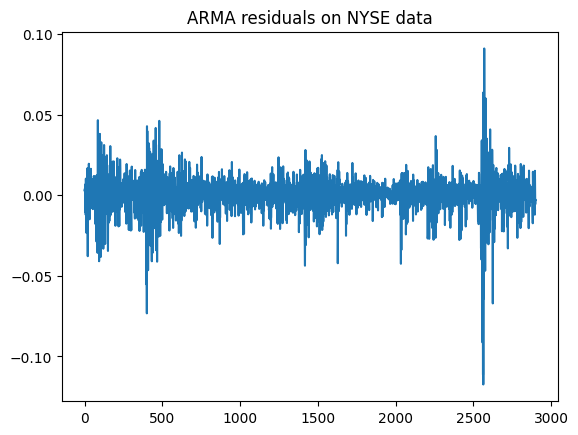

In [5]:
# Econometric baseline on NYSE data
train_df = feather.read_feather(data_dir / "cleaned_NYSE_train.feather")
val_df   = feather.read_feather(data_dir / "cleaned_NYSE_val.feather")
test_df  = feather.read_feather(data_dir / "cleaned_NYSE_test.feather")
# 1. ARMA mean
order, arma_rmse, mu_fc, arma_fit = arma_fit_forecast(
    train_df, val_df, test_df, target_col='y_next', return_fit=True
)

# 2 GARCH variance on ARMA residuals
g_rmse, g_qlike, g_nll, mu_hat, var_hat = garch_fit_forecast(
    train_df, val_df, test_df, target_col='y_next',
    dist='normal', scale=100.0,
    mu_trval=arma_fit.fittedvalues,  # train+val fitted mean
    mu_test=mu_fc                    # test mean forecasts
)

# Results
print(f"Econometric baseline on NYSE data: RMSE={arma_rmse:.6f}, QLIKE={g_qlike:.6f}, NLL={g_nll:.6f}")
resid = pd.Series(arma_fit.resid, dtype="float64").dropna().reset_index(drop=True)
plt.plot(resid.values)
plt.title("ARMA residuals on NYSE data")
plt.show()

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/state

Selected ARMA order via BIC: (1, 0, 0)
Econometric baseline on IXIC data: RMSE=0.015694, QLIKE=-7.102800, NLL=-2.632462


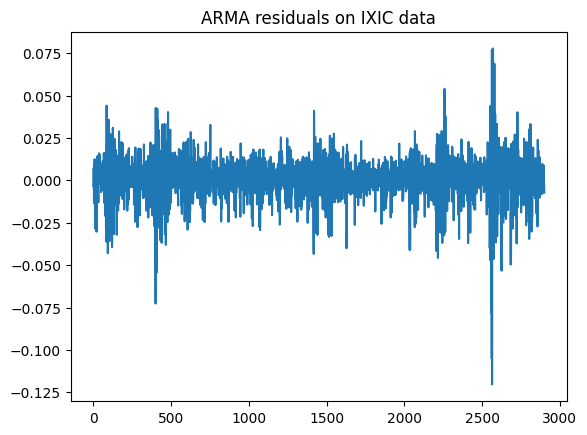

In [8]:
# Econometric baseline on IXIC data
train_df = feather.read_feather(data_dir / "cleaned_IXIC_train.feather")
val_df   = feather.read_feather(data_dir / "cleaned_IXIC_val.feather")
test_df  = feather.read_feather(data_dir / "cleaned_IXIC_test.feather")
# 1. ARMA mean
order, arma_rmse, mu_fc, arma_fit = arma_fit_forecast(
    train_df, val_df, test_df, target_col='y_next', return_fit=True
)

# 2 GARCH variance on ARMA residuals
g_rmse, g_qlike, g_nll, mu_hat, var_hat = garch_fit_forecast(
    train_df, val_df, test_df, target_col='y_next',
    dist='normal', scale=100.0,
    mu_trval=arma_fit.fittedvalues,  # train+val fitted mean
    mu_test=mu_fc                    # test mean forecasts
)

# Results
print(f"Econometric baseline on IXIC data: RMSE={arma_rmse:.6f}, QLIKE={g_qlike:.6f}, NLL={g_nll:.6f}")
resid = pd.Series(arma_fit.resid, dtype="float64").dropna().reset_index(drop=True)
plt.plot(resid.values)
plt.title("ARMA residuals on IXIC data")
plt.show()

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: 

Selected ARMA order via BIC: (3, 0, 3)
Econometric baseline on BTC data: RMSE=0.002145, QLIKE=-10.969096, NLL=-4.565610


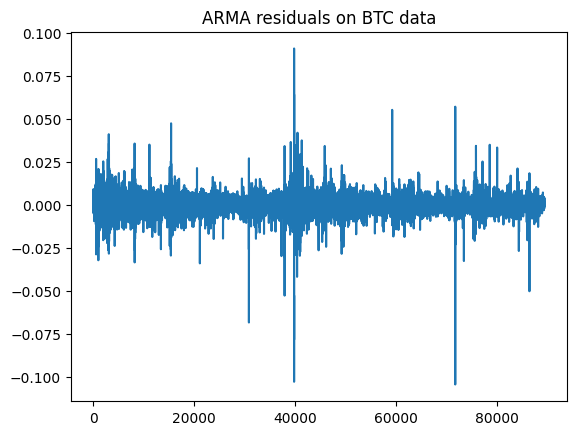

In [9]:
# Econometric baseline on BTC data
train_df = feather.read_feather(data_dir / "BTC_USDT-5m_train.feather")
val_df   = feather.read_feather(data_dir / "BTC_USDT-5m_val.feather")
test_df  = feather.read_feather(data_dir / "BTC_USDT-5m_test.feather")
# 1. ARMA mean
order, arma_rmse, mu_fc, arma_fit = arma_fit_forecast(
    train_df, val_df, test_df, target_col='y_next', return_fit=True
)

# 2 GARCH variance on ARMA residuals
g_rmse, g_qlike, g_nll, mu_hat, var_hat = garch_fit_forecast(
    train_df, val_df, test_df, target_col='y_next',
    dist='normal', scale=1000,
    mu_trval=arma_fit.fittedvalues,  # train+val fitted mean
    mu_test=mu_fc                    # test mean forecasts
)

# Results
print(f"Econometric baseline on BTC data: RMSE={arma_rmse:.6f}, QLIKE={g_qlike:.6f}, NLL={g_nll:.6f}")
resid = pd.Series(arma_fit.resid, dtype="float64").dropna().reset_index(drop=True)
plt.plot(resid.values)
plt.title("ARMA residuals on BTC data")
plt.show()

In [3]:
# Function to convert time-series data into input sequences
def create_sequences(data: pd.DataFrame, sequence_length: int, feature_columns: list, target_column: str):
    """
    Converts a time-series DataFrame into input sequences and corresponding target values.
    Args:
        data (pd.DataFrame): The pre-processed input DataFrame;
        sequence_length (int): The number of time steps in each input sequence;
        feature_columns (list): The list of the column names to be used as inout features;
        target_column (str): The name of the column to be predicted.
    Returns:
        tuple: A tuple containing the input sequences (X) and corresponding target values (y) as numpy arrays.
    """
    if target_column in feature_columns:
        raise ValueError("target_column should not be in feature_columns")
    
    # Define the features and target values
    features = data[feature_columns].values
    targets = data[target_column].values

    # Initialize lists to hold sequences and targets
    X, y = [], []
    N = len(data)
    L = sequence_length
    if N < L:
        raise ValueError(f"Data length {N} is shorter than sequence length {L}.")

    # Loop through the data to create sequences
    for i in range(0, N - L + 1):
        # The sequence of features
        seq_x = features[i:i + L]
        # The target value at the end of the sequence 
        seq_y = targets[i + L - 1]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    return X, y


In [4]:
if __name__ == "__main__":
    # Configuation
    sequence_length_map = {
        "BTC_USDT-5m": 288,
        "cleaned_IXIC": 270,
        "cleaned_NYSE": 270
    }
    target_column = 'y_next' # next-period log return
    # Data to process
    Arrow_files_prefix= [
        'cleaned_IXIC',
        'cleaned_NYSE',
        'BTC_USDT-5m'
    ]
    # Initialise a dictionary to hold all the final data
    all_processed_data = {}

    for prefix in Arrow_files_prefix:
        print(f"\n Creating Sequences for {prefix}:")

        # Step 1:  Load original data to calculate log returns
        original_path = f"/home/ubuntu/michael/MSc-Machine-Learning-Project/Datasets/Processed/{prefix}.feather"
        original_df = feather.read_feather(original_path)
        date_col = "date" if "date" in original_df.columns else "Date"
        original_df[date_col] = pd.to_datetime(original_df[date_col])
        original_df = original_df.sort_values(date_col).reset_index(drop=True)
        price_col = "Price" if "Price" in original_df.columns else "close"
        if price_col not in original_df.columns:
            raise ValueError("Expected column 'Price' or 'close' in dataframe.")
        # sanity: no non-positive prices
        if (original_df[price_col] <= 0).any():
            raise ValueError(f"Non-positive prices found in {price_col} — clean data first.")
        #Compute log_price, log_returns
        original_df["_log_price"] = np.log(original_df[price_col])
        original_df["ret_t"] = original_df["_log_price"].diff() # today's log return
        original_df["y_next"] = original_df["_log_price"].shift(-1) - original_df["_log_price"] # next period log return
        original_df = original_df.dropna(subset=["y_next"]).reset_index(drop=True)
        print("Computed log_price, ret_t and y_next inb original data.")

        # Step 2: Load the pre-processed data
        train_df = feather.read_feather(f'{data_dir}/{prefix}_train.feather')
        val_df = feather.read_feather(f'{data_dir}/{prefix}_val.feather')
        test_df = feather.read_feather(f'{data_dir}/{prefix}_test.feather')
        for df in [train_df, val_df, test_df]:
            df[date_col] = pd.to_datetime(df[date_col])
        print("Loaded pre-processed taining, validation, and test data")

        # Step 3: Define features to prevent data leakage
        columns_to_drop = ['Date', 'Name', price_col, '_log_price', "y_next"]
        feature_columns = [col for col in train_df.columns if col not in columns_to_drop and col != date_col]
        print(f"Using {len(feature_columns)} input features.")

        # Step 4: Set sequence length
        default_sequence_length = 270
        short_prefix = prefix.replace("cleaned_", "")
        seq_len = sequence_length_map.get(prefix, sequence_length_map.get(short_prefix, default_sequence_length))

        # Step 5: Create windowed sequence 
        X_train, y_train = create_sequences (train_df, seq_len, feature_columns, target_column)
        X_val, y_val = create_sequences(val_df, seq_len, feature_columns, target_column)
        X_test, y_test = create_sequences(test_df, seq_len, feature_columns, target_column)

        # Diagnostic prints
        print(f"---Shapes for {prefix}---")
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")    

        dataset_name = prefix.split('_')[-1]
        all_processed_data[dataset_name] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test
        }
        print("\nAll datasets processed.")


 Creating Sequences for cleaned_IXIC:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 50 input features.
---Shapes for cleaned_IXIC---
X_train: (2148, 270, 50), y_train: (2148,)
X_val: (215, 270, 50), y_val: (215,)
X_test: (298, 270, 50), y_test: (298,)

All datasets processed.

 Creating Sequences for cleaned_NYSE:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 49 input features.
---Shapes for cleaned_NYSE---
X_train: (2148, 270, 49), y_train: (2148,)
X_val: (215, 270, 49), y_val: (215,)
X_test: (298, 270, 49), y_test: (298,)

All datasets processed.

 Creating Sequences for BTC_USDT-5m:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 5 input features.
---Shapes for BTC_USDT-5m---
X_train: (64339, 288, 5), y_train: (64339,)
X_val: (24457, 288, 5), y_val: (24457,)
X_test: (1526

In [5]:
loaders = {}
for dataset_name, data in all_processed_data.items():
    print(f"\nCreating DataLoaders for {dataset_name}:")
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']

    train_loader, val_loader, test_loader = make_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch=64
    )
    loaders[dataset_name] = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }
    print("DataLoaders created.")


Creating DataLoaders for IXIC:
DataLoaders created.

Creating DataLoaders for NYSE:
DataLoaders created.

Creating DataLoaders for USDT-5m:
DataLoaders created.


In [6]:
budgets = (100_000, 300_000)
seeds   = (0, 1, 2)
val_ep  = max(10, num_epochs // 5)

final_tables = {}
final_details = {}

for dataset_name in all_processed_data.keys():
    print(f"\n### Param validation + training: {dataset_name}")
    train_loader, val_loader, test_loader = loaders[dataset_name]

    # wrap into the expected structure for the runner
    apd = {
        dataset_name: {
            "X_train": all_processed_data[dataset_name]["X_train"],
            "y_train": all_processed_data[dataset_name]["y_train"],
            "X_val":   all_processed_data[dataset_name]["X_val"],
            "y_val":   all_processed_data[dataset_name]["y_val"],
            "X_test":  all_processed_data[dataset_name]["X_test"],
            "y_test":  all_processed_data[dataset_name]["y_test"],
        }
    }

    df_summary, details = run_experiment_block_param_validated(
        dataset_name=dataset_name,
        all_processed_data=apd,
        budgets=budgets,
        rnn_layers_options=[1, 2, 3], 
        mamba_layers_options=[1, 2, 3], 
        seeds=seeds,
        val_epochs=val_ep,
        tol_print=6
    )
    final_tables[dataset_name] = df_summary
    final_details[dataset_name] = details


### Param validation + training: IXIC

==================== Budget 100,000 params — candidate validation ====================
RNN candidate params: 100,105, 100,233, 100,399, 99,471, 99,303, 100,741
Mamba candidate params: 101,377, 101,921, 96,769, 109,921, 84,865, 84,817
[VAL] RNN(H=291,L=1): params=100,105, val_rmse=0.008535 ±  val_std=0.0015 over 3 seeds
[VAL] RNN(H=136,L=3): params=100,233, val_rmse=0.004500 ±  val_std=0.0004 over 3 seeds
[VAL] RNN(H=174,L=2): params=100,399, val_rmse=0.007121 ±  val_std=0.0007 over 3 seeds
[VAL] RNN(H=290,L=1): params=99,471, val_rmse=0.007909 ±  val_std=0.0006 over 3 seeds
[VAL] RNN(H=173,L=2): params=99,303, val_rmse=0.006940 ±  val_std=0.0011 over 3 seeds
[VAL] RNN(H=292,L=1): params=100,741, val_rmse=0.007012 ±  val_std=0.0008 over 3 seeds
[VAL] Mamba(d_model=64, L=3): params=101,377, val_rmse=0.015180 ±  val_std=0.0003 over 3 seeds
[VAL] Mamba(d_model=80, L=2): params=101,921, val_rmse=0.014707 ±  val_std=0.0002 over 3 seeds
[VAL] Mamba(d_mo

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[VAL] Mamba(d_model=64, L=3): params=98,497, val_rmse=inf ±  val_std=nan over 3 seeds
[VAL] Mamba(d_model=80, L=2): params=98,321, val_rmse=inf ±  val_std=nan over 3 seeds
[VAL] Mamba(d_model=120, L=1): params=104,521, val_rmse=0.002484 ±  val_std=0.0002 over 3 seeds
[VAL] Mamba(d_model=112, L=1): params=91,729, val_rmse=0.002426 ±  val_std=0.0002 over 3 seeds
[VAL] Mamba(d_model=88, L=2): params=117,305, val_rmse=inf ±  val_std=nan over 3 seeds
[VAL] Mamba(d_model=128, L=1): params=117,633, val_rmse=0.002455 ±  val_std=0.0001 over 3 seeds

>>> Selected RNN for budget 100,000: RNN(H=140,L=3) (params=99,681)
Epoch 1/100 | Train Loss: 0.000134 | Val Loss: 0.000009
Epoch 10/100 | Train Loss: 0.000012 | Val Loss: 0.000007
Epoch 20/100 | Train Loss: 0.000012 | Val Loss: 0.000005
Epoch 30/100 | Train Loss: 0.000016 | Val Loss: 0.000006
Epoch 40/100 | Train Loss: 0.000111 | Val Loss: 0.000008
Epoch 50/100 | Train Loss: 0.000020 | Val Loss: 0.000008
Epoch 60/100 | Train Loss: 0.000022 | Val Lo

In [11]:
# Build seq2seq loaders for Probabilistic Mamba
def build_seq2seq_loaders(prefix, key_in_all, all_processed_data, batch_size=64):
    """
    prefix: "cleaned_NYSE" | "cleaned_IXIC" | "BTC_USDT-5m"
    key_in_all: "NYSE" | "IXIC" | "BTC"  (key in all_processed_data)
    """
    ddir = Path("/home/ubuntu/michael/MSc-Machine-Learning-Project/Datasets/Processed")
    train_df = feather.read_feather(ddir / f"{prefix}_train.feather")
    val_df   = feather.read_feather(ddir / f"{prefix}_val.feather")
    test_df  = feather.read_feather(ddir / f"{prefix}_test.feather")

    X_train = all_processed_data[key_in_all]['X_train']
    X_val   = all_processed_data[key_in_all]['X_val']
    X_test  = all_processed_data[key_in_all]['X_test']

    L = X_train.shape[1]
    input_dim = X_train.shape[2]

    def make_seq2seq_targets(df, L, target_col="y_next"):
        y = df[target_col].values
        Y = []
        for i in range(0, len(y) - L + 1):
            Y.append(y[i:i+L])
        return np.array(Y, dtype=np.float32)[..., None]  # (B, L, 1)

    Y_train = make_seq2seq_targets(train_df, L)
    Y_val   = make_seq2seq_targets(val_df,   L)
    Y_test  = make_seq2seq_targets(test_df,  L)

    trainL = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                      torch.tensor(Y_train, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=True)
    valL   = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(Y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)
    testL  = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                      torch.tensor(Y_test, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)
    return trainL, valL, testL, input_dim, L

In [12]:
def prob_head_params(d_feat: int, n_state: int, d_y: int = 1) -> int:
    # Exact param count for your ProbMambaHead
    F, n, dy = d_feat, n_state, d_y
    return (
        n*F*F               # map_B weights
        + 3*n*F             # map_B bias + map_C weights + map_sig weights  (dy=1)
        + 2*F               # gate weights + map_R weights (dy=1)
        + (5*n + 3*dy + 1)  # gate b + map_C b + map_sig b + map_R b + a_raw + q_raw + r_raw + p0
    )

def build_prob_mamba_budget_fixed_n(
    input_dim: int,
    target: int = 100_000,
    n_state: int = 16,
    n_layers: int = 1,
    d_state: int = 16, d_conv: int = 4, expand: int = 2,
    d_feat_min: int = 32, d_feat_max: int = 192, d_feat_step: int = 8,
    tol_frac: float = 0.03, verbose: bool = True,
):
    from prob_mamba.models import ProbabilisticMamba
    best = None
    mcfg = {"d_state": d_state, "d_conv": d_conv, "expand": expand}

    for F in range(d_feat_min, d_feat_max + 1, d_feat_step):
        m = ProbabilisticMamba(
            d_in=input_dim, d_feat=F, d_y=1, n_state=n_state,
            n_mamba_layers=n_layers, mamba_cfg=mcfg
        )
        p = param_count(m)
        if best is None or abs(p - target) < abs(best[1] - target):
            best = (m, p, F)
        if abs(p - target) <= tol_frac * max(1, target):
            if verbose:
                print(f"[Prob-Mamba n={n_state}] target≈{target:,} | got={p:,} | d_feat={F} | "
                      f"layers={n_layers} | head-only≈{prob_head_params(F, n_state):,}")
            return m 

    # Fallback: return the closest we found
    m, p, F = best
    if verbose:
        print(f"[Prob-Mamba n={n_state}] (closest) target≈{target:,} | got={p:,} | d_feat={F} | "
              f"layers={n_layers} | head-only≈{prob_head_params(F, n_state):,}")
    return m 

In [13]:
def train_prob_mamba_with_history(model, train_loader, val_loader, device, epochs=100, lr=1e-3, print_every=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    hist = {"train": [], "val": []}
    for ep in range(epochs):
        # --- train ---
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb, yb)         # expects y; returns dict with "nll"
            loss = out["nll"]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += loss.item() * xb.size(0)
        tr = running / len(train_loader.dataset)
        hist["train"].append(tr)

        # --- val ---
        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                running += model(xb, yb)["nll"].item() * xb.size(0)
        va = running / len(val_loader.dataset)
        hist["val"].append(va)

        if (ep+1) % print_every == 0 or ep == 0:
            print(f"[ep {ep+1:03d}] train NLL {tr:.6f} | val NLL {va:.6f}")
    return hist

def plot_nll_history(hist, every=1, title="Prob-Mamba: NLL vs epoch"):
    import matplotlib.pyplot as plt
    idx = list(range(0, len(hist["val"]), every))
    plt.figure()
    plt.plot(hist["train"], label="Train NLL", alpha=0.7)
    plt.plot(hist["val"],   label="Val NLL",   alpha=0.9)
    if every > 1:
        plt.scatter(idx, [hist["val"][i] for i in idx], s=20, label=f"Val (every {every})")
    plt.xlabel("Epoch"); plt.ylabel("NLL"); plt.title(title); plt.legend(); plt.grid(True); plt.show()

In [14]:
def train_prob_mamba(model, train_loader, val_loader, device, epochs=100, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for ep in range(epochs):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb, yb)         # expects y; returns dict with "nll"
            loss = out["nll"]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += loss.item() * xb.size(0)
        tr = running / len(train_loader.dataset)

        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                running += model(xb, yb)["nll"].item() * xb.size(0)
        va = running / len(val_loader.dataset)

        if (ep+1) % 10 == 0 or ep == 0:
            print(f"[ep {ep+1:03d}] train NLL {tr:.6f} | val NLL {va:.6f}")

In [15]:
def eval_prob_rmse_qlike_laststep(model, loader, device, eps=1e-12):
    model.eval()
    nll_total = 0.0
    se_sum = 0.0
    n_pts = 0
    qlike_sum = 0.0

    with torch.no_grad():
        for xb, yb in loader:                  # yb: (B, L, 1)
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, yb)                # use y for filtered 1-step-ahead preds
            mu  = out["y_mean"][:, -1, :].cpu().numpy().ravel()       # (B,)
            var = out["y_var_diag"][:, -1, :].cpu().numpy().ravel()   # (B,)
            yt  = yb[:, -1, :].cpu().numpy().ravel()                  # (B,)

            var = np.maximum(var, eps)
            se_sum += np.sum((mu - yt)**2)
            qlike_sum += np.sum(((yt - mu)**2) / var + np.log(var))
            n_pts += yt.size

            if "nll" in out:
                nll_total += out["nll"].item() * xb.size(0)

    rmse = math.sqrt(se_sum / n_pts)
    qlike = qlike_sum / n_pts
    nll = nll_total / len(loader.dataset) if nll_total > 0 else None
    return {"rmse": rmse, "qlike": qlike, "nll": nll}

[Prob-Mamba n=64] (closest) target≈100,000 | got=92,802 | d_feat=32 | layers=1 | head-only≈72,068
[ep 001] train NLL 797.733427 | val NLL 755.384475
[ep 010] train NLL -919.497660 | val NLL -748.534813
[ep 020] train NLL -954.361703 | val NLL -743.187683
[ep 030] train NLL -966.898518 | val NLL -740.668143
[ep 040] train NLL -963.363756 | val NLL -760.440437
[ep 050] train NLL -977.021555 | val NLL -769.087955
[ep 060] train NLL -975.331484 | val NLL -768.553373
[ep 070] train NLL -970.046884 | val NLL -793.862431
[ep 080] train NLL -974.781487 | val NLL -803.415716
[ep 090] train NLL -976.714053 | val NLL -789.313101
[ep 100] train NLL -976.157640 | val NLL -769.382015


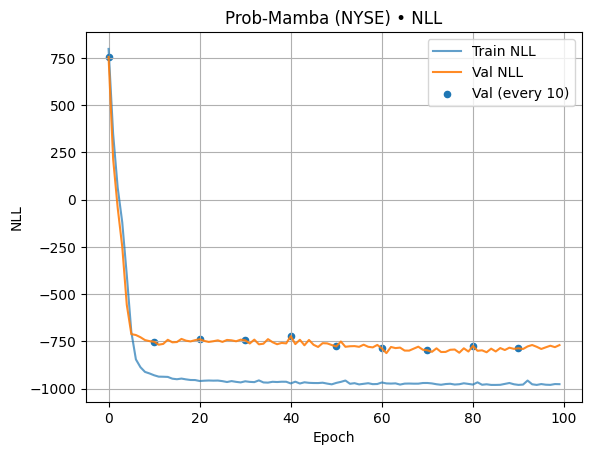

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
# Prob_mamba on NYSE data
# Build loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainL, valL, testL, input_dim, L = build_seq2seq_loaders(
    prefix="cleaned_NYSE", key_in_all="NYSE",
    all_processed_data=all_processed_data, batch_size=64
)

# Build 100k model with n_state fixed to 64
prob_mamba = build_prob_mamba_budget_fixed_n(
    input_dim=input_dim, target=100_000, n_state=64,
    n_layers=1, d_state=64, d_conv=4, expand=2,
    d_feat_min=32, d_feat_max=192, d_feat_step=8, tol_frac=0.03, verbose=True
).to(device)

# Train + record (timed)
t0 = time.perf_counter()
hist = train_prob_mamba_with_history(
    prob_mamba, trainL, valL, device=device, epochs=100, lr=1e-3, print_every=10
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
train_seconds = time.perf_counter() - t0
epochs_used = 100
n_train = len(trainL.dataset)
total_samples = epochs_used * n_train
train_throughput = (total_samples / train_seconds) if train_seconds > 0 else float("nan")
print(f"[Timing • Train] {train_seconds:.2f}s ({train_seconds/60:.2f} min) | "
      f"epochs={epochs_used} | samples={total_samples:,} | throughput={train_throughput:.1f} samples/s")

# Plot Val NLL vs epoch
plot_nll_history(hist, every=10, title="Prob-Mamba (NYSE) • NLL")

# Evaluate
metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
nll = metrics.get('nll')
nll_str = f"{nll:.6f}" if isinstance(nll, (int, float)) else "N/A"
print(f"[Prob-Mamba • NYSE] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

In [15]:
nll = metrics['nll']
nll_str = f"{nll:.6f}" if nll is not None else "N/A"
print(f"[Prob-Mamba • IXIC] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

[Prob-Mamba • IXIC] test NLL: N/A | last-step RMSE: 0.007359 | QLIKE: -8.649899


[Prob-Mamba n=64] (closest) target≈100,000 | got=92,834 | d_feat=32 | layers=1 | head-only≈72,068
[ep 001] train NLL 929.263827 | val NLL 790.954126
[ep 010] train NLL -849.974882 | val NLL -668.755244
[ep 020] train NLL -950.759107 | val NLL -707.609866
[ep 030] train NLL -967.072422 | val NLL -720.494032
[ep 040] train NLL -968.825079 | val NLL -746.335069
[ep 050] train NLL -968.295277 | val NLL -753.179635
[ep 060] train NLL -967.303725 | val NLL -744.338354
[ep 070] train NLL -971.098344 | val NLL -746.370824
[ep 080] train NLL -979.977297 | val NLL -730.747185
[ep 090] train NLL -974.730570 | val NLL -739.941742
[ep 100] train NLL -974.991187 | val NLL -716.365779
[Timing • Train] 5766.52s (96.11 min) | epochs=100 | samples=214,800 | throughput=37.2 samples/s


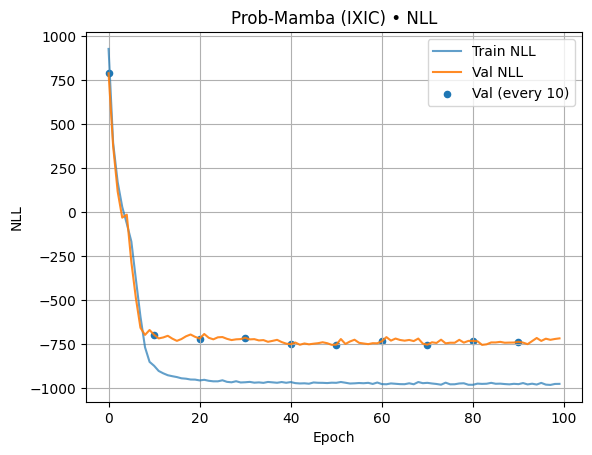

[Prob-Mamba • IXIC] test NLL: N/A | last-step RMSE: 0.009855 | QLIKE: -8.243943


In [16]:
# Prob_mamba on IXIC data
# Build loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainL, valL, testL, input_dim, L = build_seq2seq_loaders(
    prefix="cleaned_IXIC", key_in_all="IXIC",
    all_processed_data=all_processed_data, batch_size=64
)

# Build 100k model with n_state fixed to 64
prob_mamba = build_prob_mamba_budget_fixed_n(
    input_dim=input_dim, target=100_000, n_state=64,
    n_layers=1, d_state=64, d_conv=4, expand=2,
    d_feat_min=32, d_feat_max=192, d_feat_step=8, tol_frac=0.03, verbose=True
).to(device)

# Train + record (timed)
t0 = time.perf_counter()
hist = train_prob_mamba_with_history(
    prob_mamba, trainL, valL, device=device, epochs=100, lr=1e-3, print_every=10
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
train_seconds = time.perf_counter() - t0
epochs_used = 100
n_train = len(trainL.dataset)
total_samples = epochs_used * n_train
train_throughput = (total_samples / train_seconds) if train_seconds > 0 else float("nan")
print(f"[Timing • Train] {train_seconds:.2f}s ({train_seconds/60:.2f} min) | "
      f"epochs={epochs_used} | samples={total_samples:,} | throughput={train_throughput:.1f} samples/s")

# Plot Val NLL vs epoch
plot_nll_history(hist, every=10, title="Prob-Mamba (IXIC) • NLL")

# Evaluate
metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
nll = metrics.get('nll')
nll_str = f"{nll:.6f}" if isinstance(nll, (int, float)) else "N/A"
print(f"[Prob-Mamba • IXIC] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

In [16]:
# Prob_mamba on BTC data
# Build loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainL, valL, testL, input_dim, L = build_seq2seq_loaders(
    prefix="BTC_USDT-5m", key_in_all="USDT-5m",
    all_processed_data=all_processed_data, batch_size=64
)

# Build 100k model with n_state fixed to 16
prob_mamba = build_prob_mamba_budget_fixed_n(
    input_dim=input_dim, target=100_000, n_state=16,
    n_layers=1, d_state=16, d_conv=4, expand=2,
    d_feat_min=16, d_feat_max=64, d_feat_step=8, tol_frac=0.03, verbose=True
).to(device)

# Train + record (timed)
t0 = time.perf_counter()
hist = train_prob_mamba_with_history(
    prob_mamba, trainL, valL, device=device, epochs=100, lr=1e-3, print_every=10
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
train_seconds = time.perf_counter() - t0
epochs_used = 100
n_train = len(trainL.dataset)
total_samples = epochs_used * n_train
train_throughput = (total_samples / train_seconds) if train_seconds > 0 else float("nan")
print(f"[Timing • Train] {train_seconds:.2f}s ({train_seconds/60:.2f} min) | "
      f"epochs={epochs_used} | samples={total_samples:,} | throughput={train_throughput:.1f} samples/s")

# Plot Val NLL vs epoch
plot_nll_history(hist, every=10, title="Prob-Mamba (BTC) • NLL")

# Evaluate
metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
nll = metrics.get('nll')
nll_str = f"{nll:.6f}" if isinstance(nll, (int, float)) else "N/A"
print(f"[Prob-Mamba • BTC] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

[Prob-Mamba n=16] target≈100,000 | got=101,954 | d_feat=64 | layers=1 | head-only≈68,820
[ep 001] train NLL -892.382762 | val NLL -1048.893010
[ep 010] train NLL -1046.808621 | val NLL -1052.700353


KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    prob_mamba.eval()
    metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
nll = metrics.get('nll')
nll_str = f"{nll:.6f}" if isinstance(nll, (int, float)) else "N/A"
print(f"[Prob-Mamba • BTC] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

[Prob-Mamba • BTC] test NLL: N/A | last-step RMSE: 0.003995 | QLIKE: -9.044412
